### Description
- Patient visits who were transferred within 24 hours
    - ICUs to non-ICUs
    - Non-ICUs to ICUs
- Prediction differences between labels at time 0 and 24hr
- Differences between predicted values at time 0 and time 24 compared to their corresponding true labels
- Within the patient visits who were transferred:
    - More in depth about those with largest differences between the predictions at 2 time points
    - and how they are related to the differences in predicted values vs. true labels
    
Inputs:
- `1_4_cohort`
- prediction outputs for 3 labels using 1_4_cohort with light gbm

Outputs:
- `1_4_cohort_test_results` test cohort (admit year 2019 and 2020) WITH prediction results
- `1_4_cohort_diff_full_features` 318 vs 204 observations in test cohort (pred difference >= 0.3) with full features used for predictions

In [17]:
# install.packages('ggpubr')

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘ggplot2’, ‘corrplot’, ‘ggrepel’, ‘ggsci’, ‘ggsignif’, ‘polynom’, ‘rstatix’




In [1]:
library(caret) # import this before glmnet to avoid rlang version problem
library(data.table)
library(tidyverse)
library(lubridate)
# library(Matrix)
# library(glmnet)
# library(bit64)
library(pROC)
library(ROCR)
# library(rms)
library(gridExtra)
library(cowplot)
library(ggpubr)

Loading required package: lattice

Loading required package: ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::lift()      masks caret::lift()
✖ purrr::transpose() masks data.table::transpose()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Type 'citation("pROC")' for a citation.


Att

In [2]:
# directories
datadir6 = "../../DataTD/validation"
valdir = "../../OutputTD/6_validation"
modeldir6 = "../../OutputTD/6_validation/models/6_7_cohort4_all"
figuredir6 = "../../OutputTD/6_validation/figures"

options(repr.matrix.max.rows=200, repr.matrix.max.cols=30)

In [3]:
# list.files(path="modeldir4", pattern="lightgbm_test_results.csv", full.names=TRUE, recursive=FALSE)
# dir(path="modeldir4") #pattern="*.csv")

In [4]:
# check folder and sub-folders
# make sure there are no hidden dir or files .ipynb. if so, ls -a and rm them
folder <- list.dirs(modeldir6) # this assumes being in the main folder, otherwise specify the path
folder
sub.folders <- folder[-1]  # comment this out if the main folder also contains the script
# script.paths <- paste(folder,"/","process.R", sep="")
# for (i in script.paths) {source(i)}

[1] "../../OutputTD/6_validation/models/6_7_cohort4_all"                        
[2] "../../OutputTD/6_validation/models/6_7_cohort4_all/death_24hr_recent_label"
[3] "../../OutputTD/6_validation/models/6_7_cohort4_all/first_label"

In [5]:
# sub-folders, check DIR!!!
sub.folders <- list.dirs(modeldir6)[-1]
sub.folders

[1] "../../OutputTD/6_validation/models/6_7_cohort4_all/death_24hr_recent_label"
[2] "../../OutputTD/6_validation/models/6_7_cohort4_all/first_label"

In [6]:
cohort <- read.csv(file.path(valdir, '6_7_cohort4_all.csv'))
nrow(cohort) # 60464
colnames(cohort)

[1] 60464

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"

### Patient visits year and those who transferred

df2020 = df[(df['admit_time'].dt.year == 2020) & (df['admit_time'].dt.month > 3)]

In [7]:
cohort_test <-  cohort %>% mutate(admit_time = ymd_hms(admit_time)) %>% 
                    mutate(adm_year = year(admit_time), adm_month = month(admit_time),
                           transfer = ifelse(death_24hr_recent_label != first_label, 1, 0)) %>% 
                    filter(adm_year == 2021 | (adm_year == 2020 & adm_month > 3))
nrow(cohort_test) # should have 16484
table(cohort_test$adm_year)
# sum(cohort_test$transfer)

[1] 16484


2020 2021 
7465 9019 

In [8]:
summary(cohort$death_24hr_recent_label)
summary(cohort_test$death_24hr_recent_label)
summary(cohort_test$acute_to_critical_label_recent)
summary(cohort_test$critical_to_acute_label_recent)

sum(cohort_test$critical_to_acute_label_recent) #526 + 279 = 805 total transfers
sum(cohort_test$acute_to_critical_label_recent) # new: 549 + 392

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.09521 0.00000 1.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.09664 0.00000 1.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.02378 0.00000 1.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.03331 0.00000 1.00000 

[1] 549

[1] 392

### Patient visits with big differences in predictions at 2 time points

In [9]:
# for modeldir4: start at 36 "first"
for (f in sub.folders){
    print(f)
    out <- read.csv(paste0(f,"/","lightgbm_test_results.csv")) %>% select(pat_enc_csn_id_coded, predictions)
    cohort_test <- cohort_test %>% inner_join(out)
#     cohort_test[ , ncol(cohort_test) + 1] <- out$predictions
#     newcolname <- paste0("pred_", str_sub(f, start=-12))
    newcolname <- paste0("pred_", str_sub(f, start=52, end=-7)) 
    print(newcolname)
#     cohort_test <- cohort_test %>% rename(newcolname = predictions)
#     print(colnames(cohort_test))
    colnames(cohort_test)[ncol(cohort_test)] <- newcolname
}

[1] "../../OutputTD/6_validation/models/6_7_cohort4_all/death_24hr_recent_label"


Joining, by = "pat_enc_csn_id_coded"



[1] "pred_death_24hr_recent"
[1] "../../OutputTD/6_validation/models/6_7_cohort4_all/first_label"


Joining, by = "pat_enc_csn_id_coded"



[1] "pred_first"


In [10]:
colnames(cohort_test)

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "adm_year"                       
[19] "adm_month"                       "transfer"                       
[21] "pred_death_24hr_recent"          "pred_first"

### Check AUC and PRC
- highest/ recent/ first LOC
- summary of model performance 

[1] 0.9198514

[1] 0.6572378

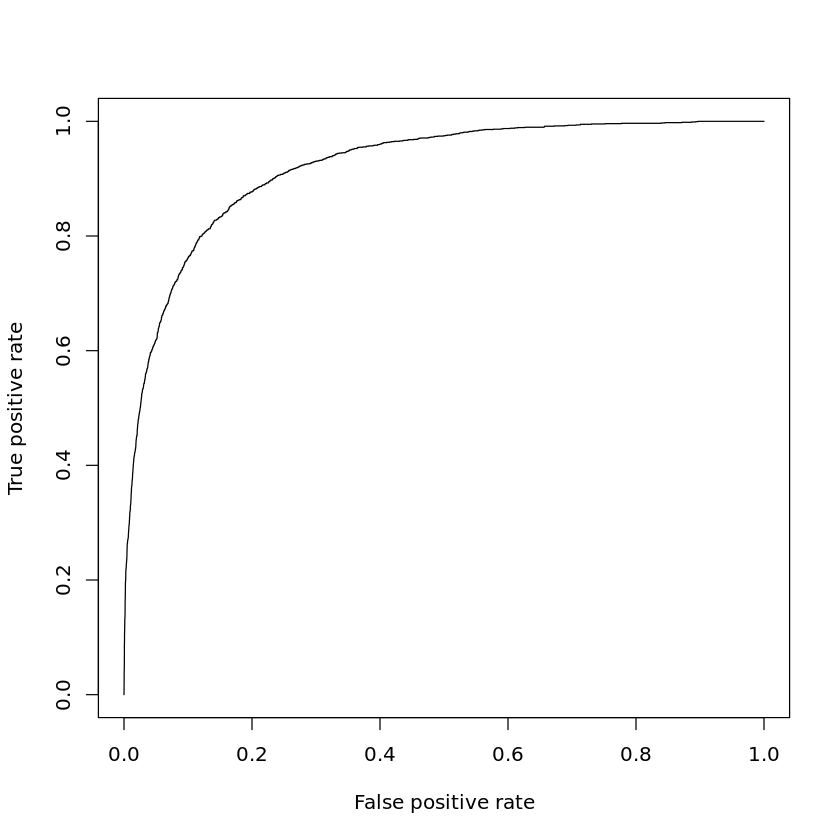

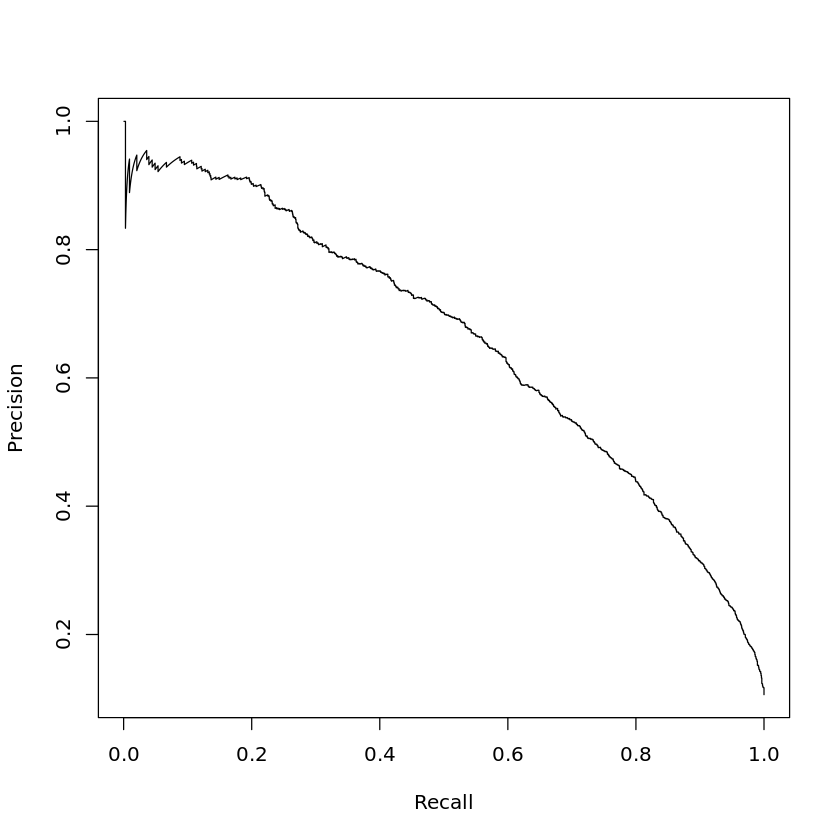

In [11]:
# get performance metrics AUC and PRC, and ACC
options(repr.plot.width=7, repr.plot.height=7)

pred_rocr = ROCR::prediction(cohort_test$pred_first, cohort_test$first_label)
auc = ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
prc = ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

PRC.perf <- ROCR::performance(pred_rocr, "prec", "rec")
ROC.perf <-  ROCR::performance(pred_rocr, "tpr", "fpr")
auc; prc # 0.92 and 0.66

plot(ROC.perf)
plot(PRC.perf)

[1] 0.8735469

[1] 0.5364987

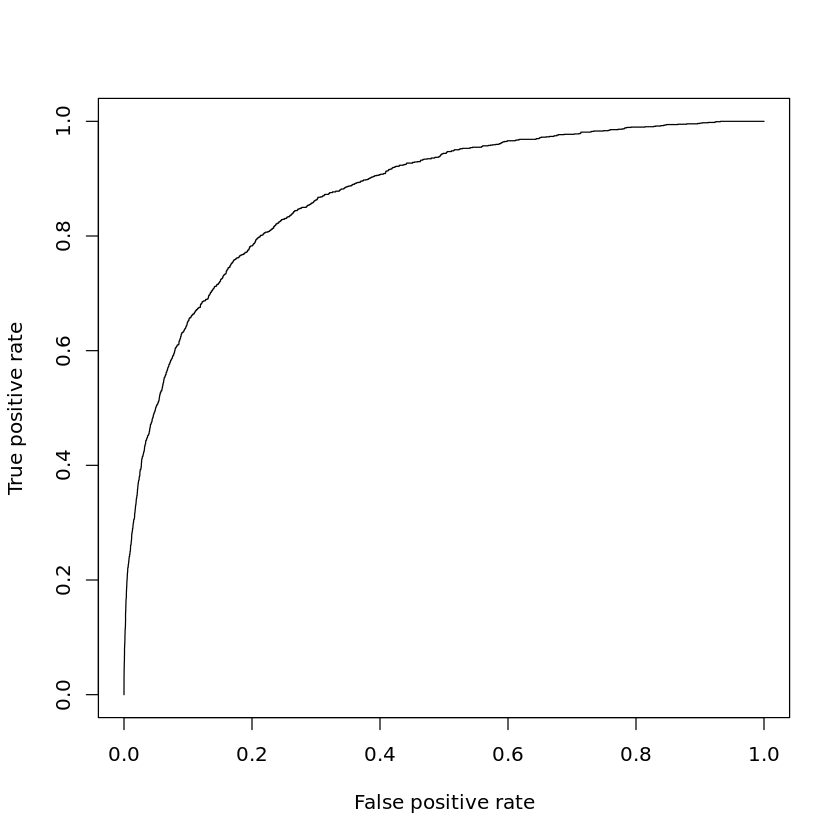

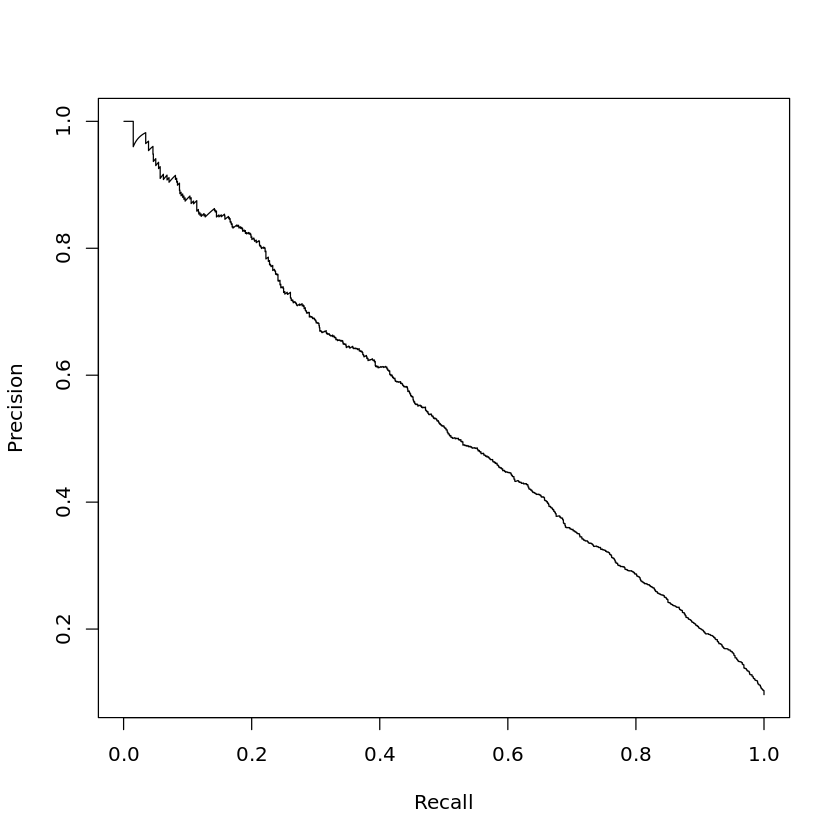

In [12]:
# get performance metrics AUC and PRC, at 24hr
options(repr.plot.width=7, repr.plot.height=7)

pred_rocr = ROCR::prediction(cohort_test$pred_death_24hr_recent, cohort_test$death_24hr_recent_label)
auc = ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
prc = ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

PRC.perf <- ROCR::performance(pred_rocr, "prec", "rec")
ROC.perf <-  ROCR::performance(pred_rocr, "tpr", "fpr")
auc; prc #0.87 and 0.54

plot(ROC.perf)
plot(PRC.perf)

### OLDER stuff

In [43]:
pred3 <- gather(cohort_test, labels, predictions, pred_death_24hr_recent:pred_first, factor_key=TRUE)
pred2 <- pred3 %>% filter(labels != 'pred_death_24hr_max')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



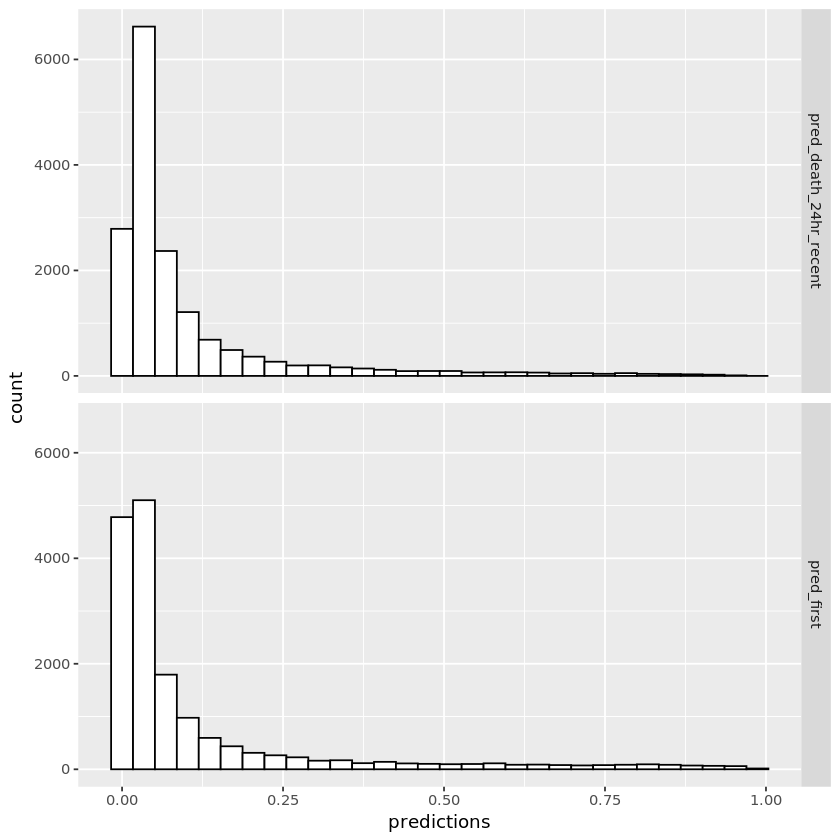

In [44]:
ggplot(pred2, aes(x = predictions)) +
  geom_histogram(fill = "white", colour = "black") +
  facet_grid(labels ~ .)

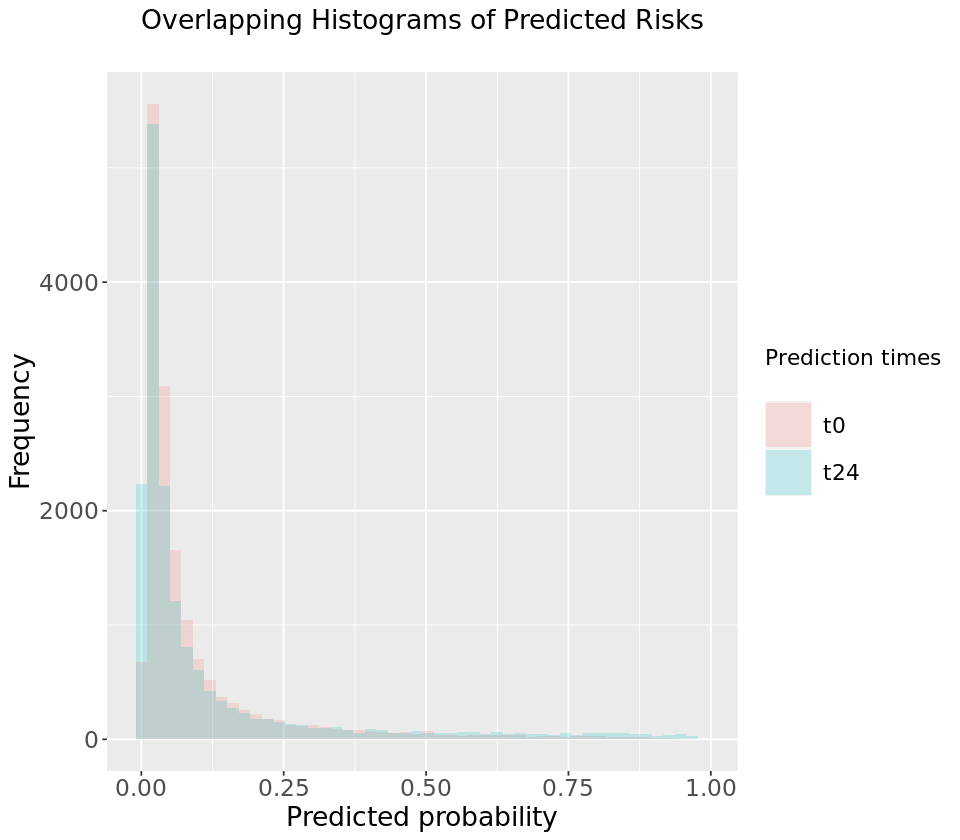

In [46]:
options(repr.plot.width=8, repr.plot.height=7)

p1 <- ggplot(pred2, aes(x = predictions, fill = labels)) + 
        geom_histogram(position = "identity", alpha = 0.2, bins = 50) +
        labs(title = "Overlapping Histograms of Predicted Risks\n", 
             x = "Predicted probability", y = "Frequency") +
        scale_fill_discrete(name = "Prediction times\n", labels = c("t0", "t24")) +
#     scale_color_manual(labels = c("Initial Admission", "24th hour after"), values = c("blue", "red")) +
        theme(axis.text = element_text(size=14),
              plot.title = element_text(size=16, hjust=0.5),
              axis.title = element_text(size=16), legend.key.size = unit(1, "cm"), 
                          legend.text=element_text(size=13), legend.title=element_text(size=13))#, face="bold"
p1
ggsave(filename = file.path(figuredir6, "Fig6.16_histograms024.png"), width = 8, height = 7, dpi = 1200) 

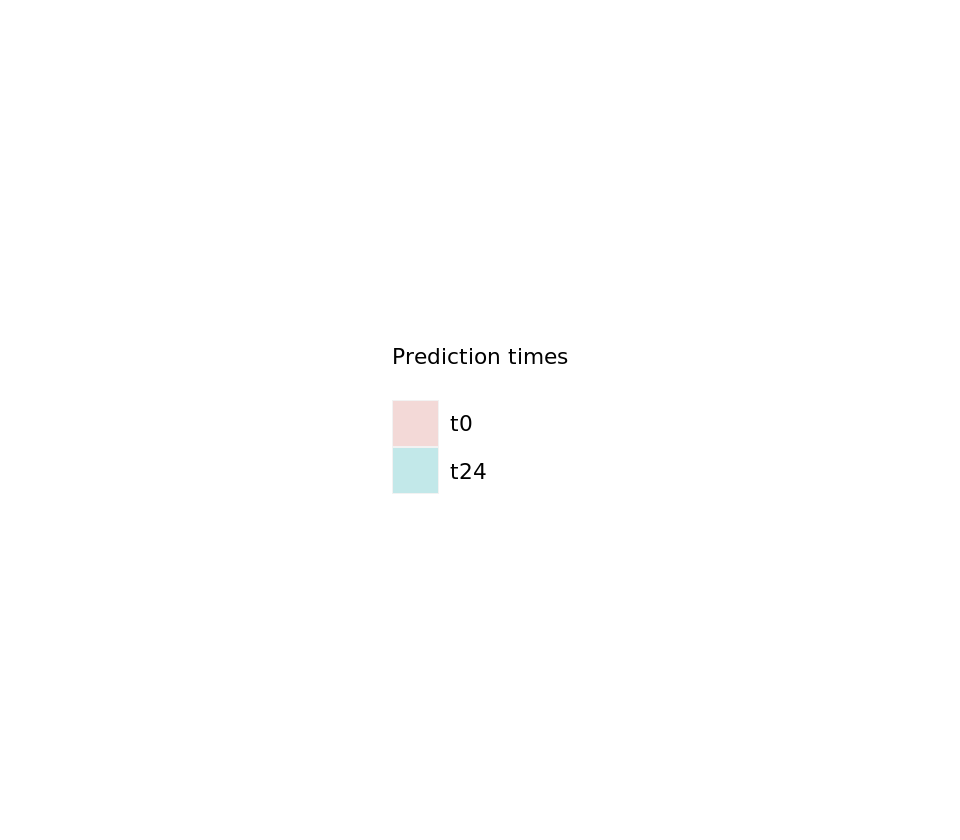

In [47]:
# library(cowplot)
my_legend <- get_legend(p1)
# library(ggpubr)
as_ggplot(my_legend)
ggsave(filename = file.path(figuredir6, "Fig6.16_histograms024_legend.png"), width = 4, height = 4, dpi = 1200) 

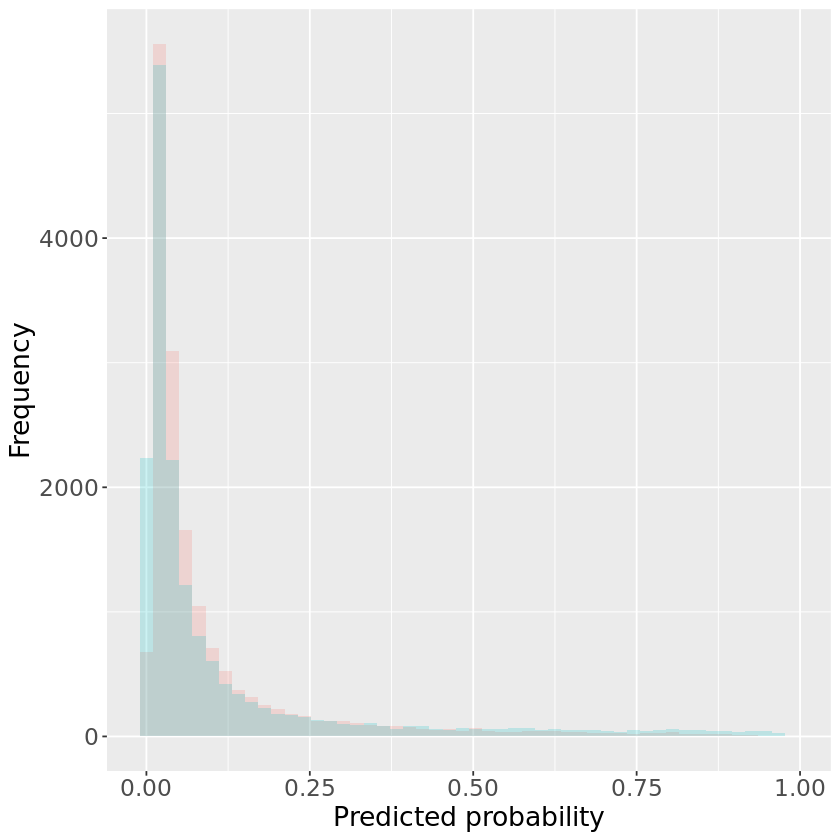

In [48]:
options(repr.plot.width=7, repr.plot.height=7)

p2 <- ggplot(pred2, aes(x = predictions, fill = labels)) + 
        geom_histogram(position = "identity", alpha = 0.2, bins = 50) +
        labs(# title = "Histograms of predicted risks\n", 
             x = "Predicted probability", y = "Frequency") +
#         scale_fill_discrete(name = "Prediction Times\n", labels = c("initial admission", "24th hour after")) +
#         scale_color_manual(labels = c("Initial Admission", "24th hour after"), values = c("blue", "red")) +
        theme(axis.text = element_text(size=14),
              plot.title = element_text(size=16, hjust=0.5),
              legend.position = 'none',
              axis.title = element_text(size=16)) #, legend.key.size = unit(1, "cm"), 
#                           legend.text=element_text(size=13), legend.title=element_text(size=13))#, face="bold"
p2
ggsave(filename = file.path(figuredir6, "Fig6.16_histograms024_notitle.png"), width=7, height=7, dpi=1200) 

### check differences: diff =  p0 - p24

In [49]:
cohort_test <- cohort_test %>% mutate(diff0_24 = round(pred_first - pred_death_24hr_recent, 2),
                                      abs_diff0_24 = round(abs(pred_first - pred_death_24hr_recent), 1),
                                      transfer = ifelse(first_label != death_24hr_recent_label, 1, 0),
                                      diff0_True = round(pred_first - first_label, 2),
                                      diff24_True = round(pred_death_24hr_recent - death_24hr_recent_label, 2))

In [50]:
nrow(cohort_test)
colnames(cohort_test)
summary(cohort_test)

[1] 16484

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "adm_year"                       
[19] "adm_month"                       "transfer"                       
[21] "pred_death_24hr_recent"          "pred_first"                     
[23] "diff0_24"                        "abs_diff0_24"                   
[25] "diff0_True"                      "diff24_True"

   anon_id          pat_enc_csn_id_coded inpatient_data_id_coded
 Length:16484       Min.   :1.313e+11    Min.   :51964995       
 Class :character   1st Qu.:1.313e+11    1st Qu.:57273662       
 Mode  :character   Median :1.313e+11    Median :62306884       
                    Mean   :1.313e+11    Mean   :62534719       
                    3rd Qu.:1.313e+11    3rd Qu.:67813306       
                    Max.   :1.313e+11    Max.   :73231043       
                                                                
   admit_time                   label_max24     label_24hr_recent
 Min.   :2020-04-01 01:31:00   Min.   :0.0000   Min.   :0.00000  
 1st Qu.:2020-09-10 05:02:45   1st Qu.:0.0000   1st Qu.:0.00000  
 Median :2021-01-26 21:51:00   Median :0.0000   Median :0.00000  
 Mean   :2021-01-21 14:32:29   Mean   :0.1349   Mean   :0.09597  
 3rd Qu.:2021-06-09 03:45:00   3rd Qu.:0.0000   3rd Qu.:0.00000  
 Max.   :2021-09-30 07:00:00   Max.   :1.0000   Max.   :1.00000  
                  

5%   10%   20%   30%   40%   50%   60%   70%   80%   90%   95% 
-0.05 -0.03 -0.02 -0.01 -0.01  0.00  0.00  0.01  0.03  0.10  0.18

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.47000 -0.01000  0.00000  0.01687  0.01000  0.74000 

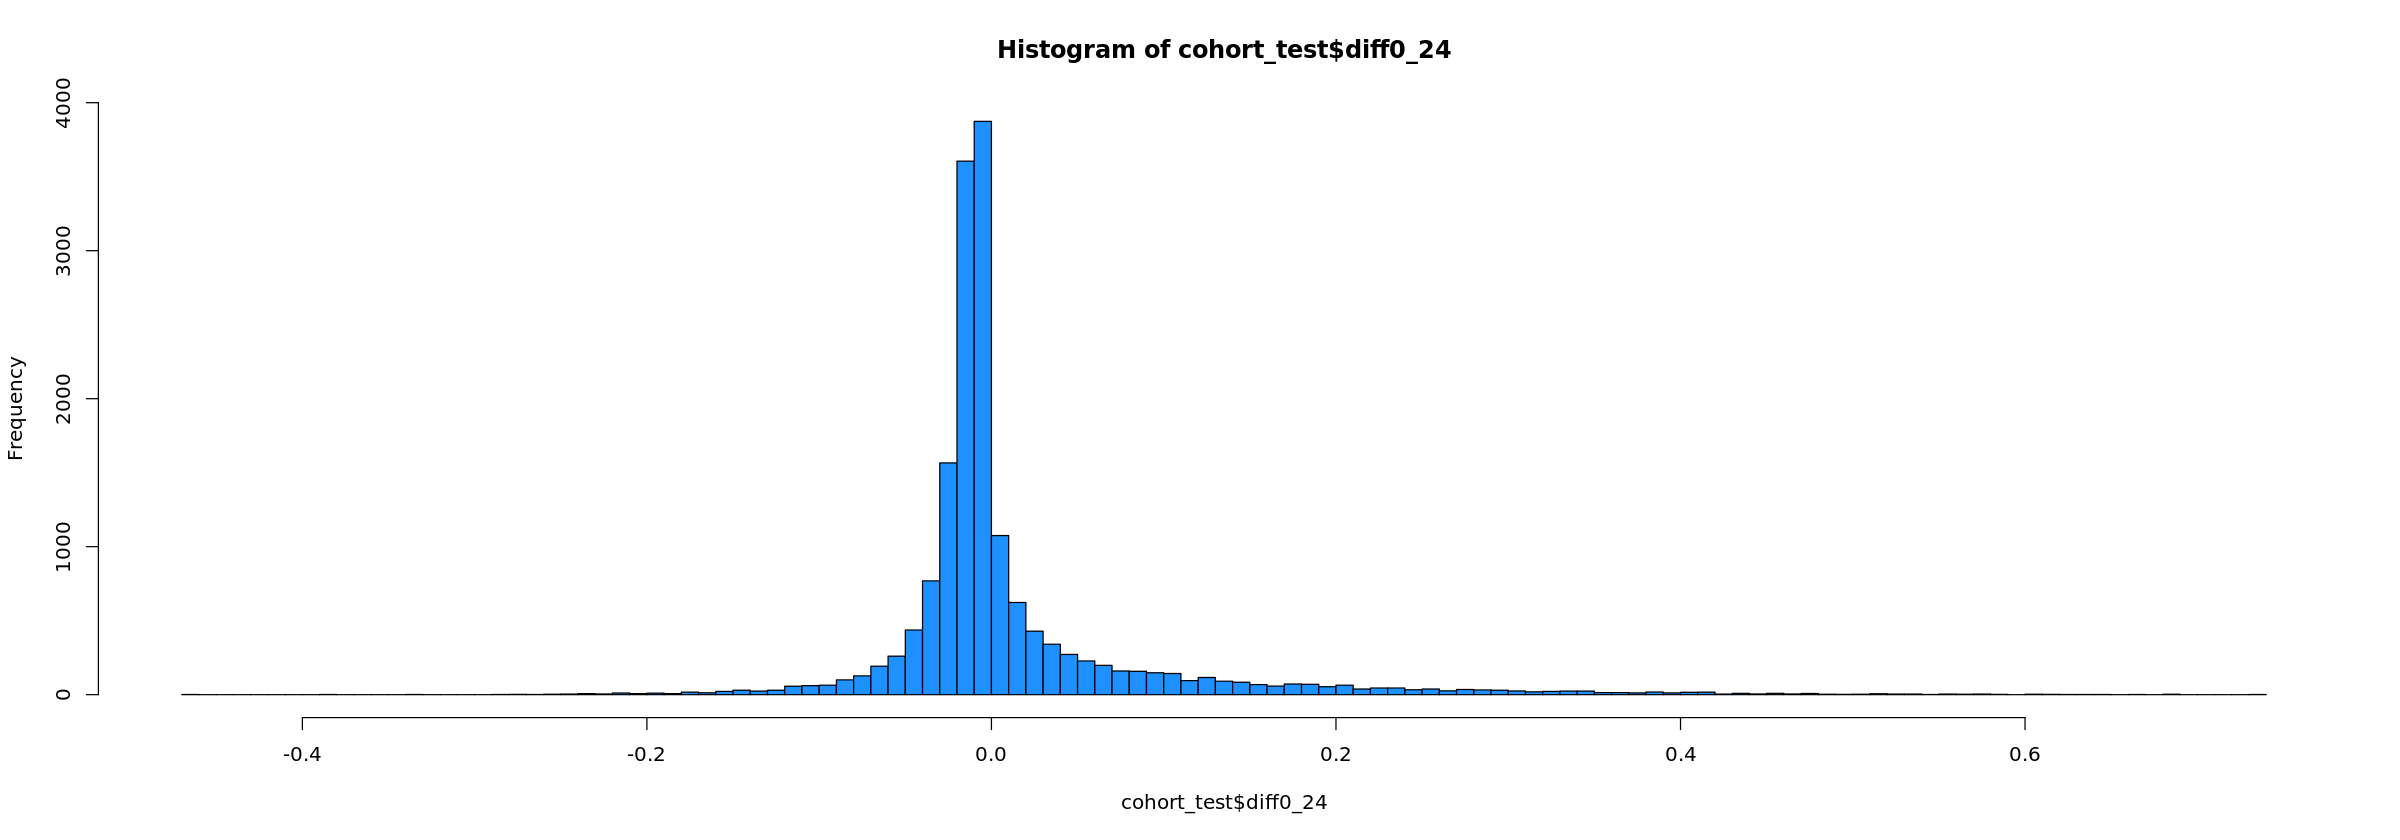

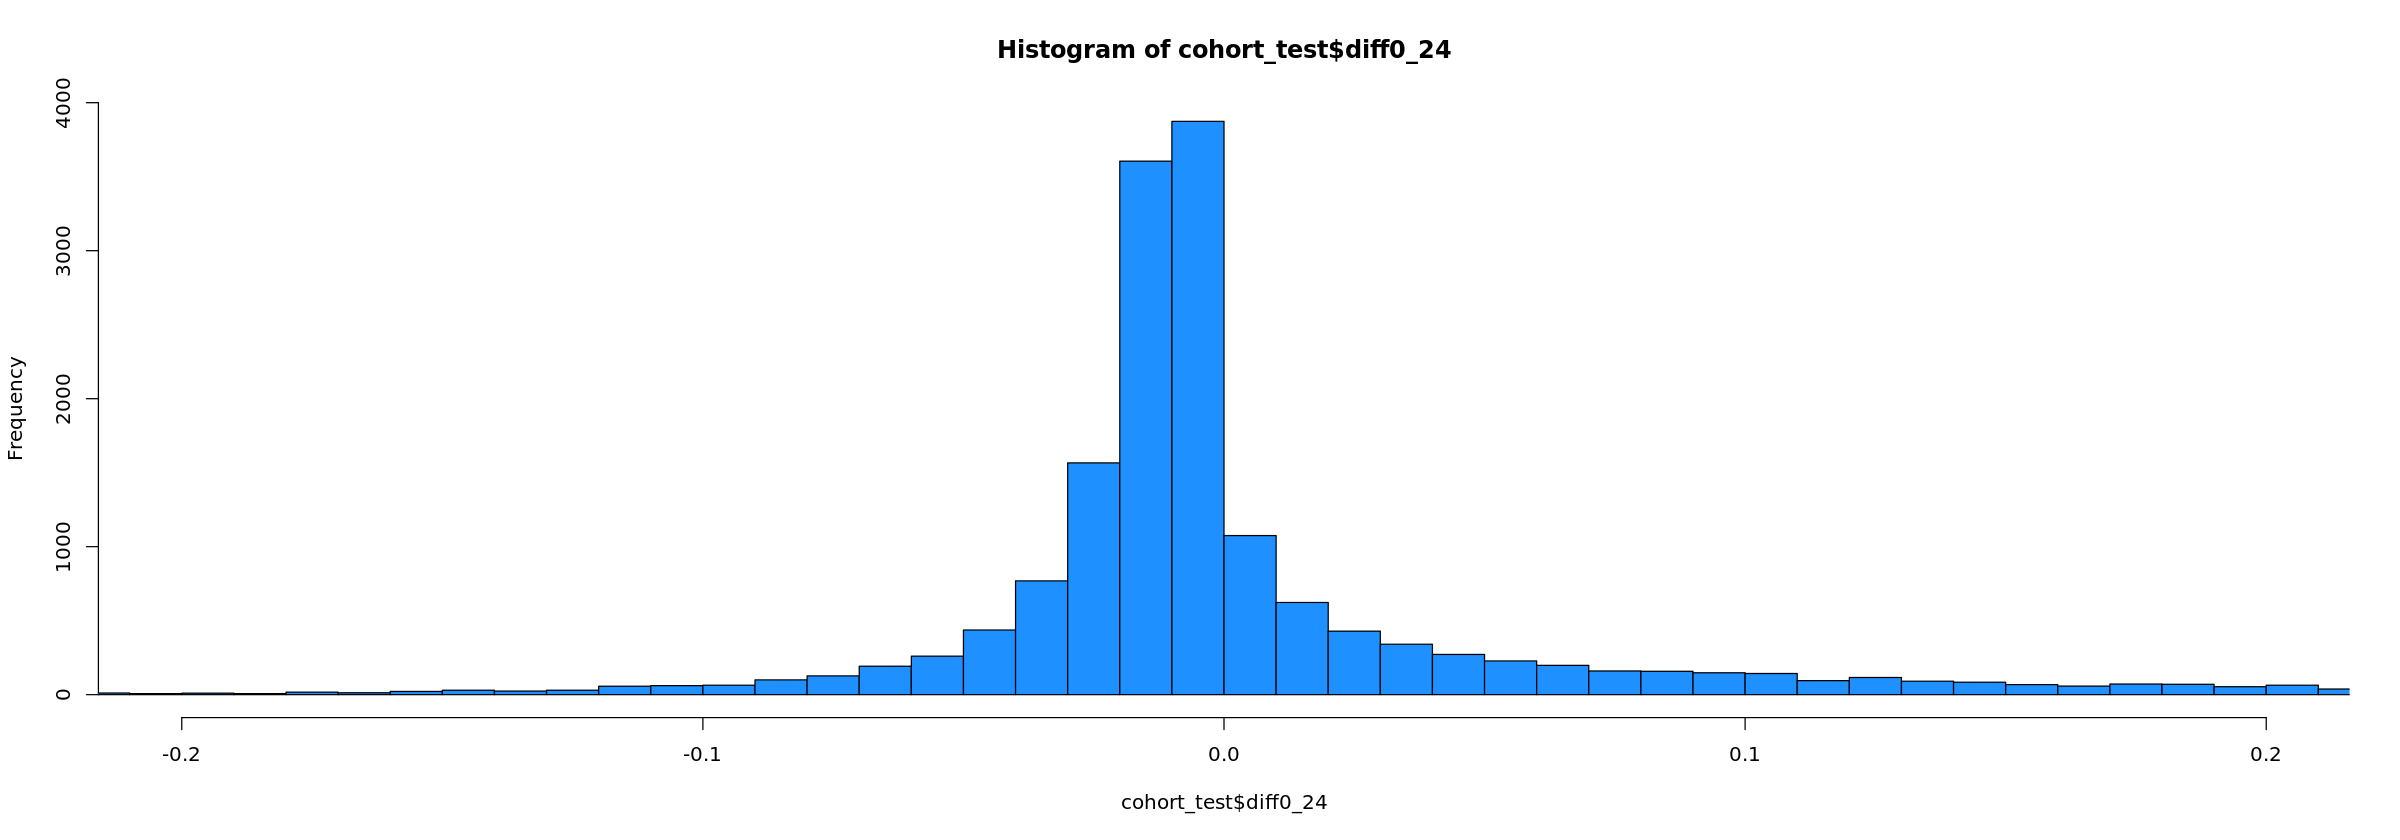

In [51]:
options(repr.plot.width=20, repr.plot.height=7)

quantile(cohort_test$diff0_24, c(.05, .1, .2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95)) 
summary(cohort_test$diff0_24)
hist(cohort_test$diff0_24, col='dodgerblue', breaks=100)
hist(cohort_test$diff0_24, col='dodgerblue', breaks=100, xlim=c(-0.2, 0.2))

ERROR: Error in file.path(figuredir, "Fig6.16_histdiff.png"): object 'figuredir' not found


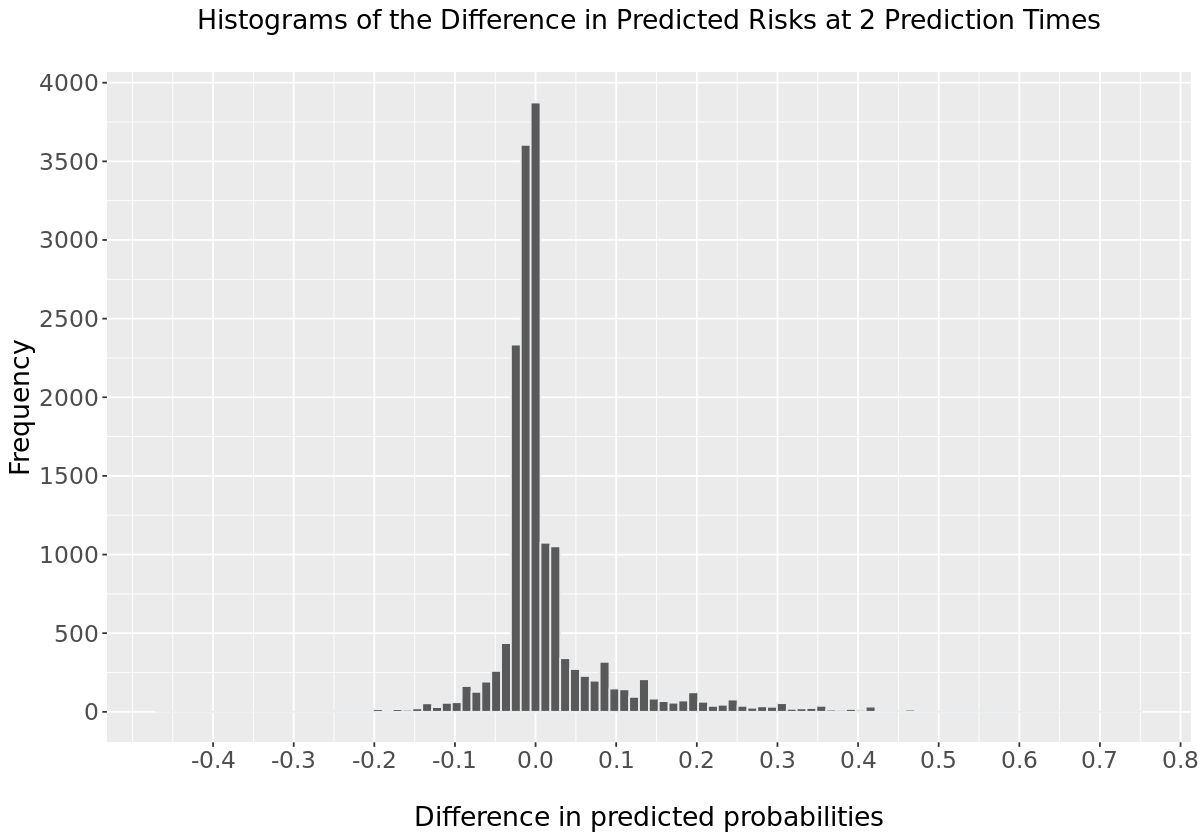

In [52]:
options(repr.plot.width=10, repr.plot.height=7)

p3 <- ggplot(cohort_test, aes(x = diff0_24)) +
        geom_histogram(position = "identity", color="#e9ecef", bins = 100) +
        labs(title = "Histograms of the Difference in Predicted Risks at 2 Prediction Times\n",
             x = "\nDifference in predicted probabilities", y = "Frequency") +
        scale_x_continuous(breaks = seq(-0.4, 0.8, by = 0.1)) +
        scale_y_continuous(breaks = seq(0, 4000, by = 500)) +
        theme(axis.text = element_text(size=14),
              plot.title = element_text(size=16, hjust=0.5),
              axis.title = element_text(size=16))
p3
ggsave(filename = file.path(figuredir, "Fig6.16_histdiff.png"), width=10, height=7, dpi=1200) 

In [53]:
sum(cohort_test$diff0_24 < - 0.3)
cohort_test1 <- cohort_test %>% mutate(d0_24 = round(diff0_24, 1), abs_d0_24 = round(abs_diff0_24, 1))
cohort_test1 %>% group_by(d0_24) %>% 
            summarise(nrows = n(), count_csn = n_distinct(pat_enc_csn_id_coded), count_mrn = n_distinct(anon_id)) %>% 
            arrange(-d0_24) %>% mutate(cum_csn = cumsum(count_csn), cum_mrn = cumsum(count_mrn))

cohort_test1 %>% group_by(abs_d0_24) %>% 
            summarise(nrows = n(), count_csn = n_distinct(pat_enc_csn_id_coded), count_mrn = n_distinct(anon_id)) %>% 
            arrange(-abs_d0_24) %>% mutate(cum_csn = cumsum(count_csn), cum_mrn = cumsum(count_mrn))

[1] 3

d0_24,nrows,count_csn,count_mrn,cum_csn,cum_mrn
<dbl>,<int>,<int>,<int>,<int>,<int>
0.7,6,6,6,6,6
0.6,21,21,21,27,27
0.5,44,44,44,71,71
0.4,121,121,120,192,191
0.3,275,275,269,467,460
0.2,547,547,538,1014,998
0.1,1421,1421,1352,2435,2350
0.0,13251,13251,10328,15686,12678
-0.1,707,707,656,16393,13334


abs_d0_24,nrows,count_csn,count_mrn,cum_csn,cum_mrn
<dbl>,<int>,<int>,<int>,<int>,<int>
0.7,5,5,5,5,5
0.6,21,21,20,26,25
0.5,50,50,50,76,75
0.4,131,131,130,207,205
0.3,283,283,278,490,483
0.2,670,670,654,1160,1137
0.1,2312,2312,2135,3472,3272
0.0,13012,13012,10152,16484,13424


In [54]:
# diff <- cohort_test %>% arrange(-abs_diff0_24) %>% 
#         mutate(rec = 1, pround = round(abs_diff0_24, 1)) %>% 
#         group_by(pround) %>% mutate(psum = sum(rec)) %>% 
#         distinct(pround, psum) %>%
#         filter(pround > 0) #%>% mutate(cumsize = cumsum(psum)) # %>% select(-rec)

# diff$cumsize <- cumsum(diff$psum)

nrow(cohort_test %>% filter(abs_diff0_24 >= 0.3))
diff <- cohort_test %>% 
            group_by(abs_diff0_24) %>% summarise(count = n()) %>% arrange(-abs_diff0_24) %>% 
            mutate(cum_count = cumsum(count), cumperc = round(100*cum_count/nrow(cohort_test), 2)) 

diff

[1] 490

abs_diff0_24,count,cum_count,cumperc
<dbl>,<int>,<int>,<dbl>
0.7,5,5,0.03
0.6,21,26,0.16
0.5,50,76,0.46
0.4,131,207,1.26
0.3,283,490,2.97
0.2,670,1160,7.04
0.1,2312,3472,21.06
0.0,13012,16484,100.00


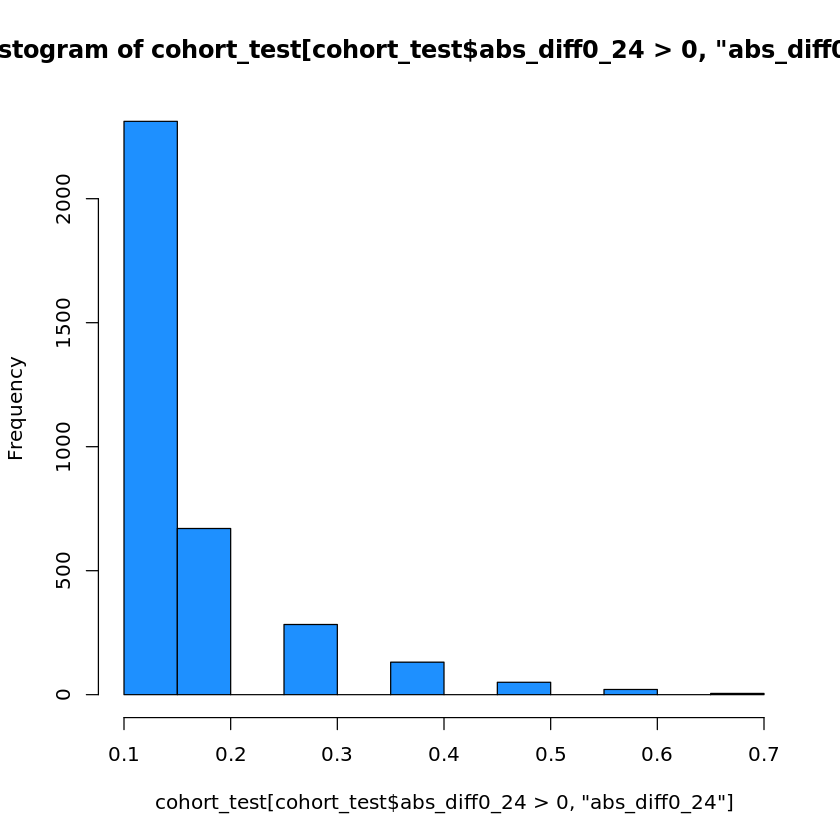

In [55]:
# threshold and size plot
options(repr.plot.width=7, repr.plot.height=7)

# absolute count
hist(cohort_test[cohort_test$abs_diff0_24 > 0, 'abs_diff0_24'], col='dodgerblue')

In [56]:
# this remained the same after updating coh4 to remove obs with labs and vitals > 24hr pre admit
diff[diff$abs_diff0_24 > 0.1,]$cum_count

[1]    5   26   76  207  490 1160

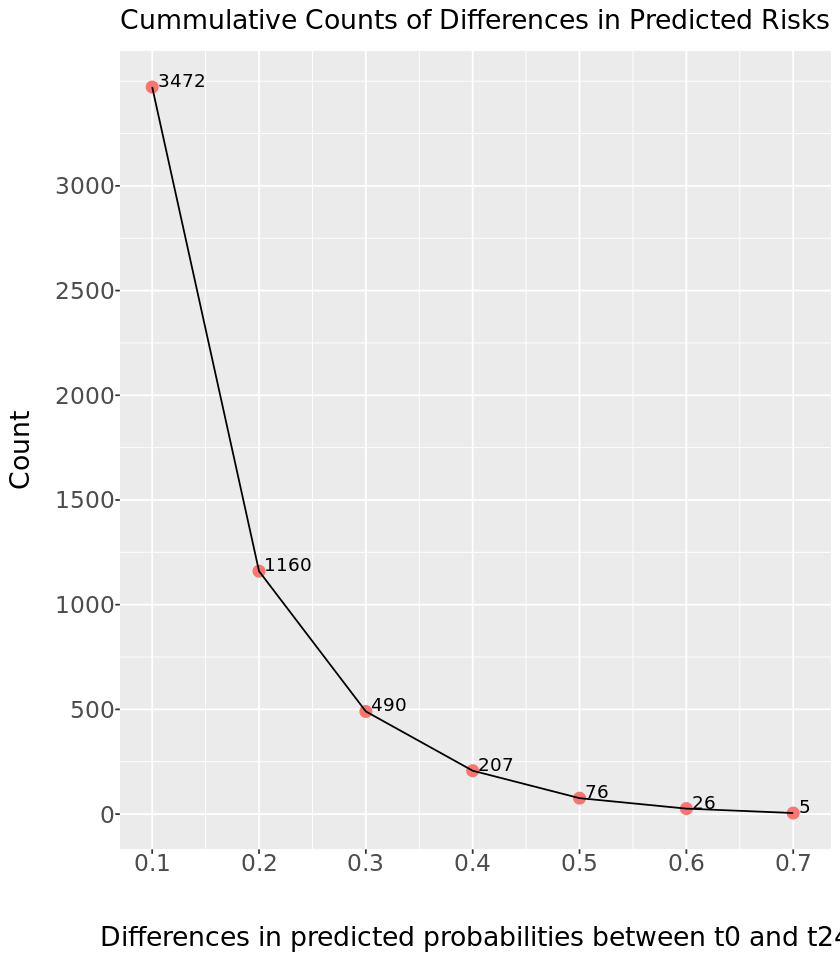

In [58]:
#### cummulative count
options(repr.plot.width=7, repr.plot.height=8)

p4 <- ggplot(diff[diff$abs_diff0_24 > 0, ], aes(x=abs_diff0_24, y=cum_count)) + 
        geom_point(color = "#F8766D", size = 3) + geom_line() +
        geom_text(label=diff[diff$abs_diff0_24 > 0, ]$cum_count, hjust = 0, nudge_x = 0.005, vjust =0) + 
        labs(x="\nDifferences in predicted probabilities between t0 and t24", y="Count", 
                   title = "Cummulative Counts of Differences in Predicted Risks") +
        scale_x_continuous(breaks = seq(0, 0.8, by = 0.1)) +
        scale_y_continuous(breaks = seq(0, 3000, by = 500)) +
        theme(axis.text=element_text(size=14),
              axis.text.x = element_text(margin=margin(0, 0, 10, 0)), #color = "red", 
              axis.text.y = element_text(margin=margin(0, 0, 0, 10)), #color = "red",
              plot.title = element_text(size=16, hjust=0.5, margin=margin(0, 0, 10, 0)),
              axis.title=element_text(size=16),
              legend.key.size = unit(1, "cm"))#, face="bold"
p4
ggsave(filename = file.path(figuredir6, "Fig6.16_count_differences.png"), width=7, height=8, dpi=1200) 

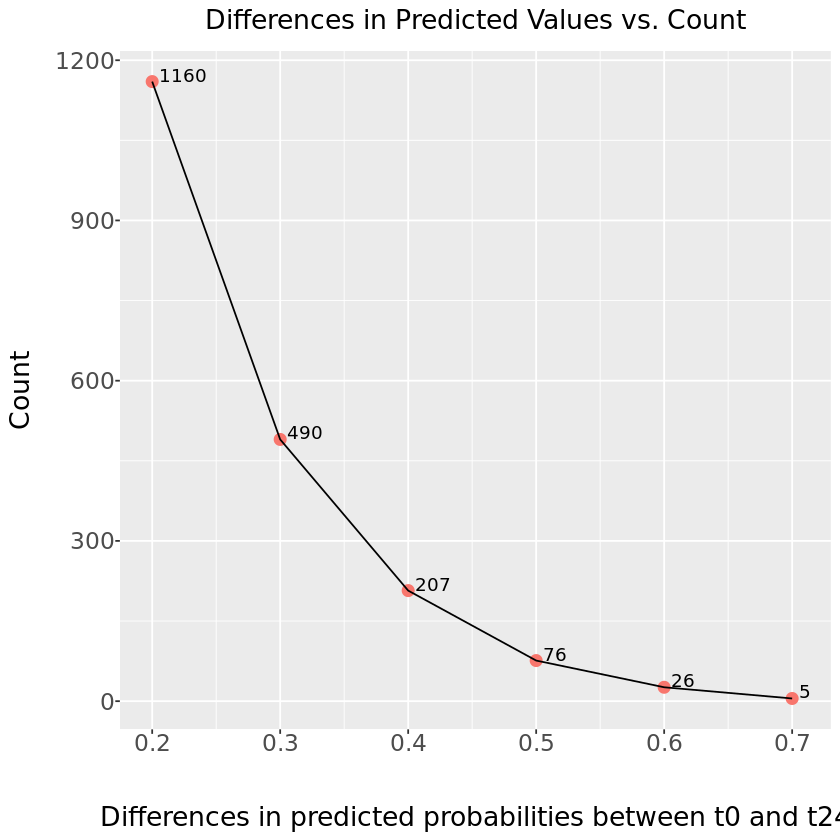

In [59]:
# cummulative count
options(repr.plot.width=7, repr.plot.height=7)

ggplot(diff[diff$abs_diff0_24 > 0.1, ], aes(x=abs_diff0_24, y=cum_count)) + 
    geom_point(color = "#F8766D", size = 3) + geom_line() +
    geom_text(label=diff[diff$abs_diff0_24 > 0.1, ]$cum_count, hjust = 0, nudge_x = 0.005, vjust =0) + 
    labs(x="\nDifferences in predicted probabilities between t0 and t24", y="Count", 
               title = "Differences in Predicted Values vs. Count") +
    theme(axis.text=element_text(size=14),
          axis.text.x = element_text(margin=margin(0, 0, 10, 0)), #color = "red", 
          axis.text.y = element_text(margin=margin(0, 0, 0, 10)), #color = "red",
          plot.title = element_text(size=16, hjust=0.5, margin=margin(0, 0, 10, 0)),
          axis.title=element_text(size=16),
          legend.key.size = unit(1, "cm"))#, face="bold"


In [60]:
cohort_test <- cohort_test %>% mutate(gradient = ifelse(abs_diff0_24 >= 0.4, 1, abs_diff0_24))
#                                                             ifelse(abs_diff0_24 < 0.4 & abs_diff0_24 >=0.3, 0.7, 
#                                                                    ifelse(abs_diff0_24 < 0.2 & abs_diff0_24 >= 0.2, 0.4, 0.2))))

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



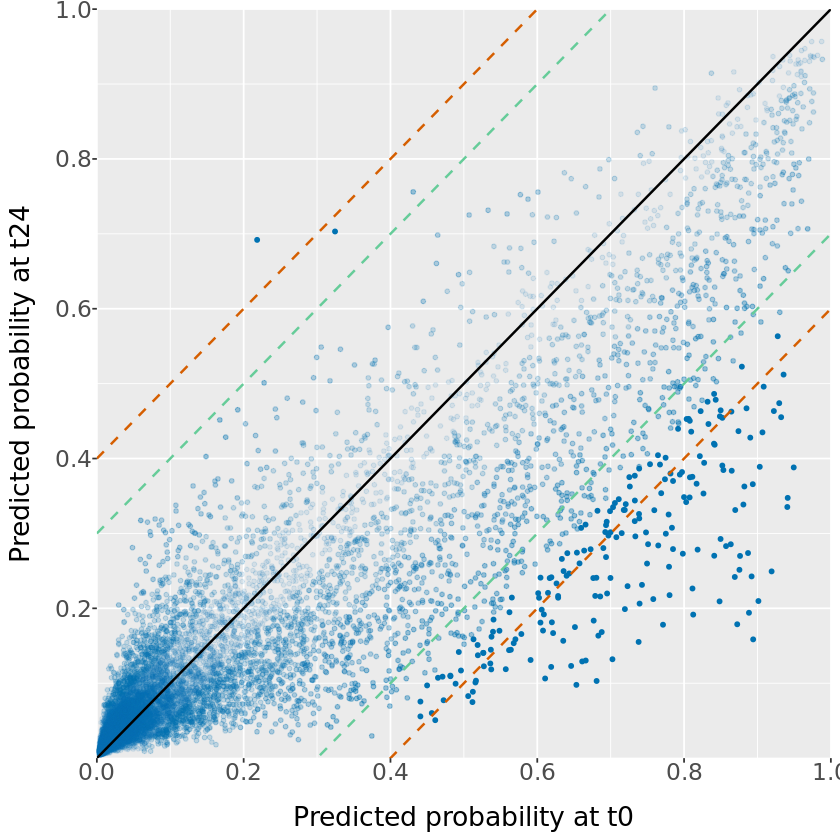

In [61]:
options(repr.plot.width=7, repr.plot.height=7)

# select alpha = abs_diff0_24 or alpha = gradient
# hide legend
p5 <- ggplot(cohort_test, aes(x=pred_first, y=pred_death_24hr_recent)) + 
        geom_point(color = "#0072B2", size = 1, aes(alpha = gradient)) + xlim(0,1) + ylim(0,1) +
        geom_abline(intercept = 0, slope = 1, size = 0.7) +
        geom_abline(intercept = 0.4, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
        geom_abline(intercept = -0.4, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
        geom_abline(intercept = 0.3, slope = 1, size = 0.7, linetype=2, color = "#66CC99") +
        geom_abline(intercept = -0.3, slope = 1, size = 0.7, linetype=2, color = "#66CC99") +
        scale_x_continuous(name = "Predicted probability at t0", expand = c(0, 0), limits=c(0, 1), 
                           breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1)) + 
        scale_y_continuous(name = "Predicted probability at t24", expand = c(0, 0), limits=c(0, 1), 
                           breaks=c(0.2, 0.4, 0.6, 0.8, 1)) +
        theme(axis.text=element_text(size=14),
              axis.text.x = element_text(margin=margin(0, 0, 10, 0)),
              axis.text.y = element_text(margin=margin(0, 0, 0, 10)),
              plot.title = element_text(size=16, hjust=0.5, margin=margin(0, 0, 10, 0)),
              axis.title = element_text(size=16),
              legend.position = "none") #+
#         labs(title = "Predicted Risks at t0 vs t24")
p5
ggsave(filename = file.path(figuredir6, "Fig6.16_scatterplot_notitle.png"), width=7, height=7, dpi=1200) 

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



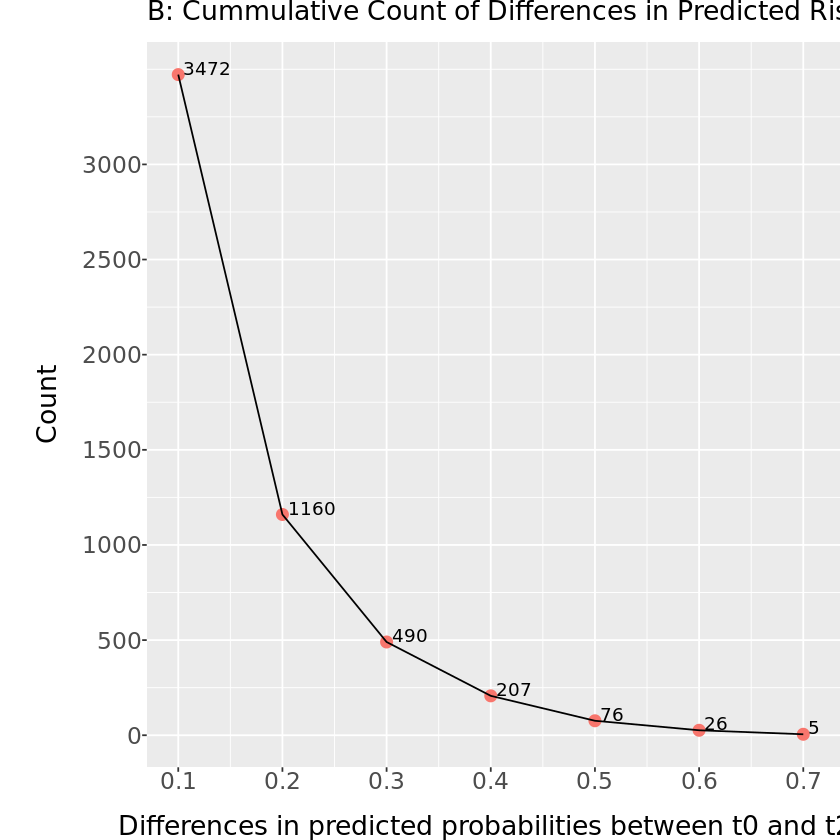

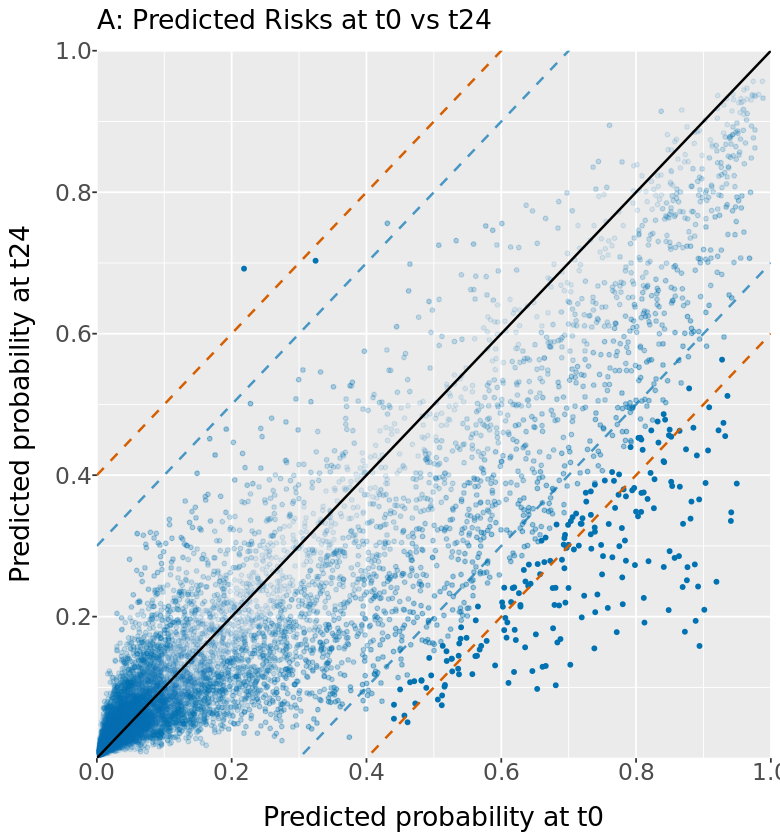

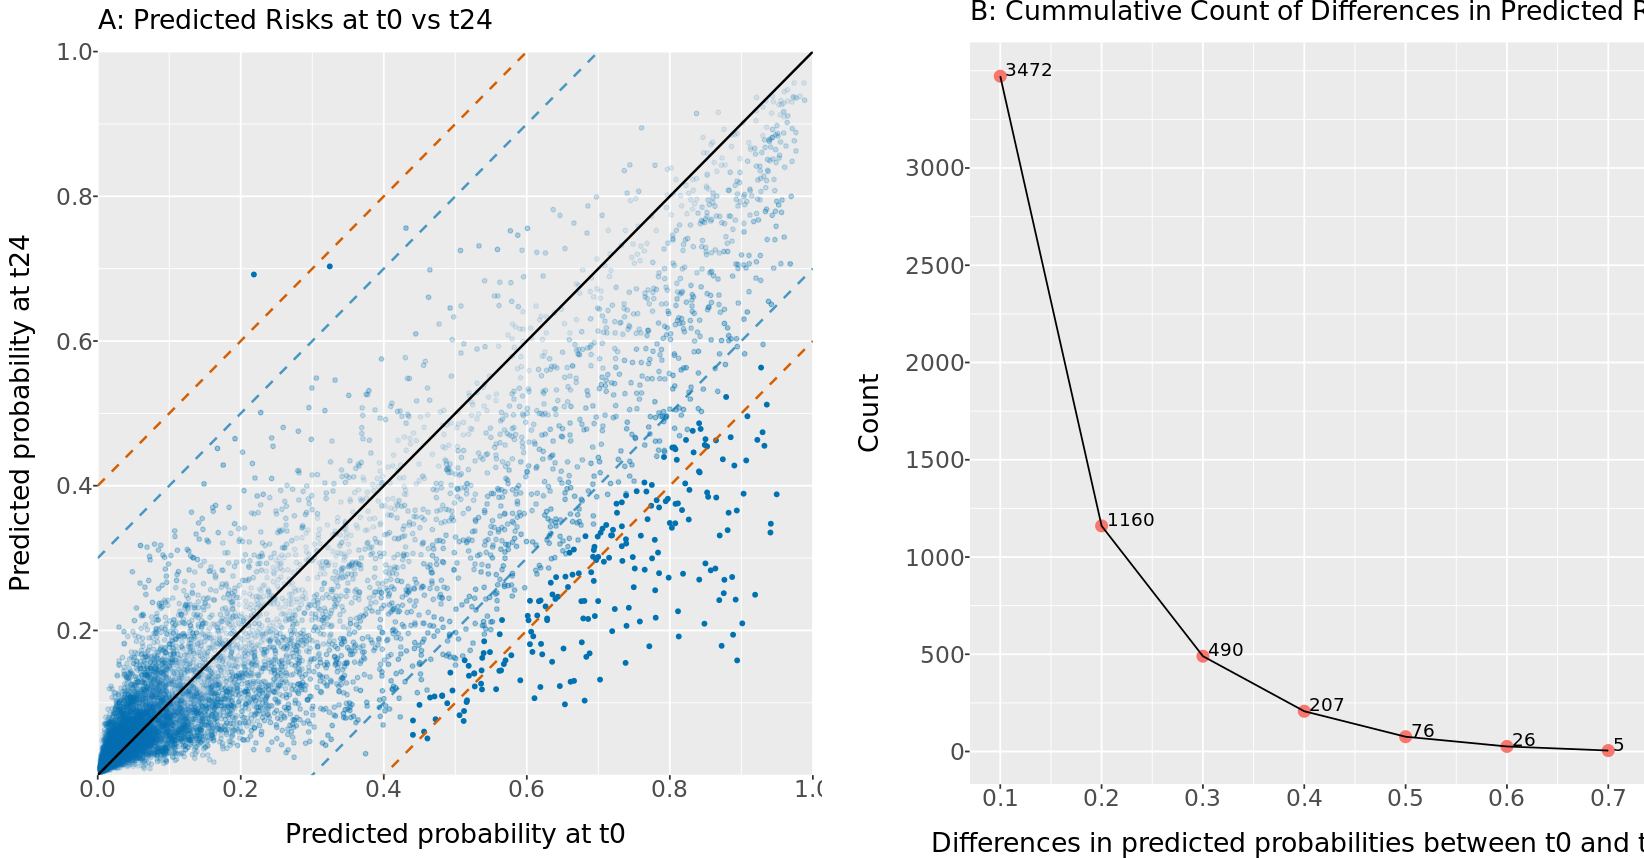

In [62]:
options(repr.plot.width=7, repr.plot.height=7)
# options(repr.plot.width=7.5, repr.plot.height=7.5)

p6 <- ggplot(diff[diff$abs_diff0_24 > 0, ], aes(x=abs_diff0_24, y=cum_count)) + 
        geom_point(color = "#F8766D", size = 3) + geom_line() +
        geom_text(label=diff[diff$abs_diff0_24 > 0, ]$cum_count, hjust = 0, nudge_x = 0.005, vjust =0) + 
        labs(x="Differences in predicted probabilities between t0 and t24", y="Count",
             title = "B: Cummulative Count of Differences in Predicted Risks") +
        scale_x_continuous(breaks = seq(0, 0.8, by = 0.1)) +
        scale_y_continuous(breaks = seq(0, 3000, by = 500)) +
        theme(axis.text=element_text(size=14),
              axis.text.x = element_text(margin=margin(0, 0, 10, 0)), #color = "red", 
              axis.text.y = element_text(margin=margin(0, 0, 0, 10)), #color = "red",
              plot.title = element_text(size=16, margin=margin(0, 0, 10, 0)),
              axis.title=element_text(size=16),
              plot.margin = unit(c(0, 0, 0, 0.3), "inch"))#, face="bold"
p6

options(repr.plot.width=6.5, repr.plot.height=7)
# options(repr.plot.width=7, repr.plot.height=7.5)

p7 <- ggplot(cohort_test, aes(x=pred_first, y=pred_death_24hr_recent)) + 
        geom_point(color = "#0072B2", size = 1, aes(alpha = gradient)) + xlim(0,1) + ylim(0,1) +
        geom_abline(intercept = 0, slope = 1, size = 0.7) +
        geom_abline(intercept = 0.4, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
        geom_abline(intercept = -0.4, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
        geom_abline(intercept = 0.3, slope = 1, size = 0.7, alpha = 0.7, linetype=2, color = "#0072B2") +
        geom_abline(intercept = -0.3, slope = 1, size = 0.7, alpha = 0.7, linetype=2, color = "#0072B2") +
        scale_x_continuous(name = "Predicted probability at t0", expand = c(0, 0), limits=c(0, 1), 
                           breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1)) + 
        scale_y_continuous(name = "Predicted probability at t24", expand = c(0, 0), limits=c(0, 1), 
                           breaks=c(0.2, 0.4, 0.6, 0.8, 1)) +
        theme(axis.text=element_text(size=14),
              axis.text.x = element_text(margin=margin(0, 0, 10, 0)),
              axis.text.y = element_text(margin=margin(0, 0, 0, 10)),
              plot.title = element_text(size=16, margin=margin(0, 0, 10, 0)),
              axis.title = element_text(size=16),
              legend.position = "none") + #,
#               plot.margin = unit(c(0, 0, 0, 1), "inch")) + # t, r, b, l
        labs(title = "A: Predicted Risks at t0 vs t24")
p7

# put p7 and p6 side-by-side
options(repr.plot.width=13.7, repr.plot.height=7.15)
# options(repr.plot.width=14.5, repr.plot.height=7.5) # unable to view on GDrive

# grid.arrange(p6, p7, ncol=2)

# to save side-by-side picture
# plotlist <- list(p6, p7)
plot_grid(plotlist=list(p7, p6))

# no "page 1 of 1" on top of the saved fig as with glist from gridExtra
ggsave(filename = file.path(figuredir6, "Fig6.16_diff_count_side_by_sideAB.png"), width = 13.7, height = 7.15, dpi = 1200) 

In [21]:
# write.csv(cohort_test, file.path(modeldir4, "1_4_cohort_test_results.csv"), row.names=FALSE)

### Get all features used for prediction for the test cohort

In [22]:
orders5 <- read.csv(file.path(datadir, 'coh5_order_code_counts.csv'))
nrow(orders5) # should have 5730678

[1] 4760662

In [26]:
orders4 <- read.csv(file.path(datadir, 'coh4_order_code_counts.csv')) %>% 
            mutate(admit_time = ymd_hms(admit_time),
                   feature_type = ifelse(str_detect(feature_type, "Microbiology"), "Microbiology", feature_type))
nrow(orders4) # 6086852

[1] 6086852

In [27]:
values <- read.csv(file.path(featuredir, '2_7_coh4_feature_values.csv')) %>% 
                    mutate(admit_time = ymd_hms(admit_time), time = ymd_hms(time),
                           hr_before_admit = round(as.numeric(difftime(admit_time, time, unit="hours")), 1))
nrow(values) #3085046

[1] 3085046

In [28]:
colnames(orders4)
colnames(values)
colnames(cohort_test)
nrow(cohort_test)

[1] "anon_id"              "pat_enc_csn_id_coded" "admit_time"          
[4] "feature_type"         "features"             "values"

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "admit_time"              "first_label"            
 [5] "death_24hr_recent_label" "death_24hr_max_label"   
 [7] "feature_type"            "features"               
 [9] "values"                  "time"                   
[11] "hr_before_admit"

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "adm_year"                       
[19] "transfer"                        "pred_death_24hr_max"            
[21] "pred_death_24hr_recent"          "pred_first"                     
[23] "diff0_24"                        "abs_diff0_24"                   
[25] "diff0_True"                      "diff24_True"

[1] 12418

In [18]:
# cohort_test with absdiff at least 0.1
cohort_test_diff01 <- cohort_test %>% select(anon_id, pat_enc_csn_id_coded, admit_time, 
                                      first_label, death_24hr_recent_label, death_24hr_max_label,
                                      pred_first, pred_death_24hr_recent, transfer, 
                                      abs_diff0_24, diff0_True, diff24_True) %>% 
                    filter(abs_diff0_24 >= 0.1)

In [21]:
cohort_diff <- cohort_test %>% select(anon_id, pat_enc_csn_id_coded, admit_time, 
                                      first_label, death_24hr_recent_label, death_24hr_max_label,
                                      pred_first, pred_death_24hr_recent, transfer, 
                                      abs_diff0_24, diff0_True, diff24_True) %>% 
                    filter(abs_diff0_24 >= 0.3)

In [22]:
diff_cohort_orders <- left_join(cohort_diff, orders4)
diff_cohort_values <- left_join(cohort_diff, values) 
length(unique(diff_cohort_orders$pat_enc_csn_id_coded))
length(unique(diff_cohort_values$pat_enc_csn_id_coded))

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time")

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time", "first_label", "death_24hr_recent_label", "death_24hr_max_label")



[1] 323

[1] 323

In [30]:
nrow(diff_cohort_orders)
nrow(diff_cohort_values) # only 1 less than before 
diff_cohort_orders %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)
diff_cohort_values %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)

[1] 40883

[1] 30806

feature_type,n
<chr>,<int>
Microbiology,206
Procedures,513
Imaging,1837
Lab,6357
Meds,12453
Diagnosis,19517


feature_type,n
<chr>,<int>
demo,5491
vitals,12513
labs,12802


In [31]:
diff_cohort_full_features <- full_join(diff_cohort_orders, diff_cohort_values) 
nrow(diff_cohort_full_features) # only 1 less
nrow(diff_cohort_orders) + nrow(diff_cohort_values)
length(unique(diff_cohort_full_features$pat_enc_csn_id_coded))
diff_cohort_full_features %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time", "first_label", "death_24hr_recent_label", "death_24hr_max_label", "pred_first", "pred_death_24hr_recent", "transfer", "abs_diff0_24", "diff0_True", "diff24_True", "feature_type", "features", "values")



[1] 71689

[1] 71689

[1] 323

feature_type,n
<chr>,<int>
Microbiology,206
Procedures,513
Imaging,1837
demo,5491
Lab,6357
Meds,12453
vitals,12513
labs,12802
Diagnosis,19517


In [32]:
# write.csv(diff_cohort_full_features, file.path(modeldir4, "1_4_cohort_diff_full_features.csv"), row.names=FALSE)

### Patient visits predictions vs. truth


In [33]:
summary(cohort_test$diff0_True)
summary(cohort_test$diff24_True)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.990000  0.010000  0.030000 -0.007673  0.070000  0.930000 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.990000  0.020000  0.030000 -0.005754  0.070000  0.900000 

In [34]:
diff3 <- gather(cohort_test, diffs, values, diff0_24:diff24_True, factor_key=TRUE)
diff2 <- diff3 %>% filter(diffs != 'diff0_24')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



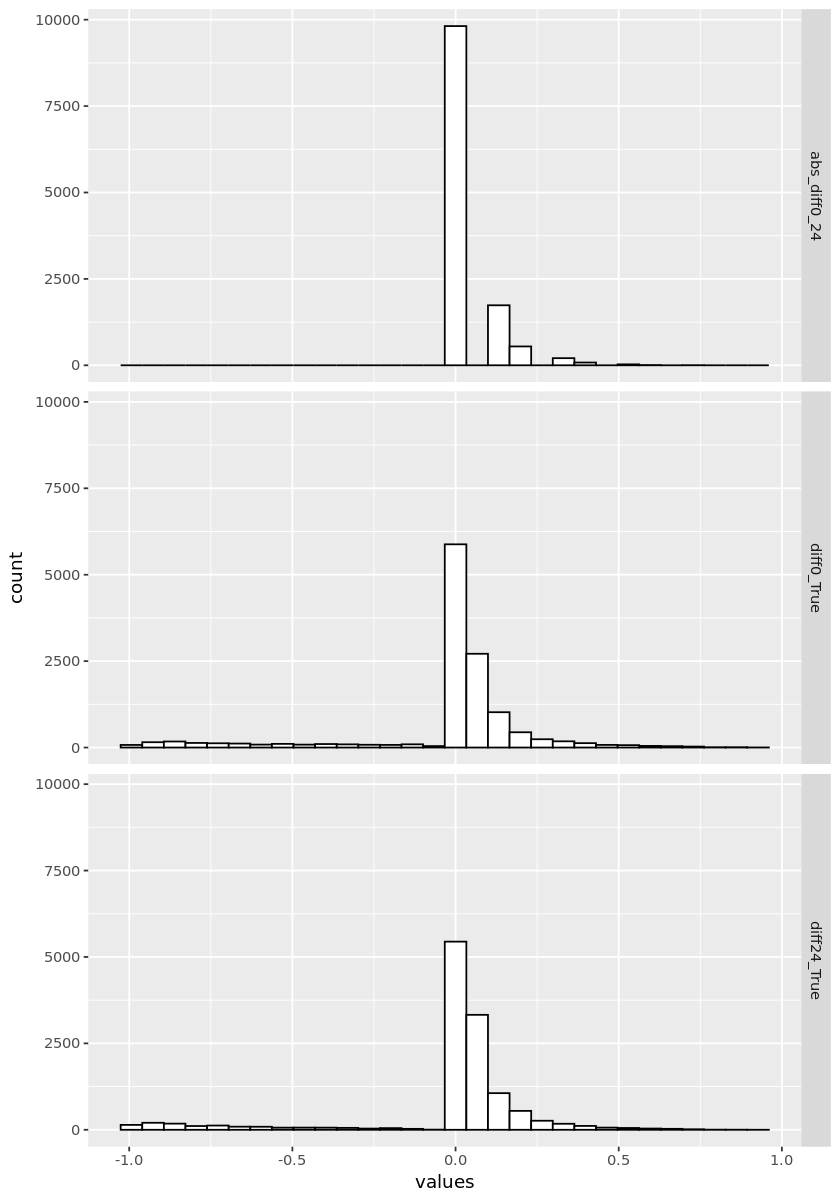

In [35]:
options(repr.plot.width=7, repr.plot.height=10)

ggplot(diff2, aes(x = values)) +
  geom_histogram(fill = "white", colour = "black") +
  facet_grid(diffs ~ .)

### 

### Check most difference first (33 vs 37)
- 0.7 or more: 3 vs 4
- 0.6 or more: 11 vs 10
- 0.5 or more: 19 vs 23

In [36]:
diff

abs_diff0_24,count,cum_count,cumperc
<dbl>,<int>,<int>,<dbl>
0.7,3,3,0.02
0.6,7,10,0.08
0.5,27,37,0.30
0.4,80,117,0.94
0.3,206,323,2.60
0.2,545,868,6.99
0.1,1736,2604,20.97
0.0,9814,12418,100.00


### Get the full data for the cohort for exploratory analysis

In [37]:
cohort <- cohort %>% mutate(admit_time = ymd_hms(admit_time)) 

In [38]:
cohort_orders <- inner_join(cohort, orders4)
cohort_values <- inner_join(cohort, values)

cohort_orders %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)
cohort_values %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)

length(unique(cohort$pat_enc_csn_id_coded))

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time")

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time", "death_24hr_max_label", "death_24hr_recent_label", "first_label")



feature_type,n
<chr>,<int>
Microbiology,39017
Procedures,51696
Imaging,299944
Lab,993484
Meds,1868195
Diagnosis,2834516


feature_type,n
<chr>,<int>
demo,747660
vitals,978717
labs,1358669


[1] 43980

In [39]:
colnames(cohort_orders)
colnames(cohort_values)

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "feature_type"                   
[19] "features"                        "values"

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "feature_type"                   
[19] "features"                        "values"                         
[21] "time"                            "hr_before_admit"

In [40]:
head(cohort_orders, 1)
head(cohort_values, 1)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,feature_type,features,values
,<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>
1,JCd97296,1.31176e+11,18290644,2016-02-06 22:31:00,0,0,NA,0,0,0,0,0,1325,0,0,0,0,Lab,CBC WITH DIFFERENTIAL,2


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,feature_type,features,values,time,hr_before_admit
,<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dttm>,<dbl>
1,JCd97296,1.31176e+11,18290644,2016-02-06 22:31:00,0,0,NA,0,0,0,0,0,1325,0,0,0,0,demo,ESI_i,2,NA,NA


In [41]:
cohort_full <- bind_rows(cohort_orders, cohort_values)
nrow(cohort_full) # 9171898
nrow(cohort_orders) + nrow(cohort_values)
length(unique(cohort_full$pat_enc_csn_id_coded))
cohort_full %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)

[1] 9171898

[1] 9171898

[1] 43980

feature_type,n
<chr>,<int>
Microbiology,39017
Procedures,51696
Imaging,299944
demo,747660
vitals,978717
Lab,993484
labs,1358669
Meds,1868195
Diagnosis,2834516


In [42]:
head(cohort_full, 1)
tail(cohort_full, 1)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,feature_type,features,values,time,hr_before_admit
,<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dttm>,<dbl>
1,JCd97296,1.31176e+11,18290644,2016-02-06 22:31:00,0,0,NA,0,0,0,0,0,1325,0,0,0,0,Lab,CBC WITH DIFFERENTIAL,2,NA,NA


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,feature_type,features,values,time,hr_before_admit
,<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dttm>,<dbl>
9171898,JCdeb097,131261813349,33702913,2019-02-06 12:21:00,0,0,0,1,0,0,0,0,0,0,0,0,0,labs,O2sat_v,82,2019-02-06 08:46:00,3.6


In [43]:
# write.csv(cohort_full, file.path(featuredir, "1_4_cohort_full_features.csv"), row.names=FALSE)

In [44]:
cohort_full %>% filter(is.na(feature_type)) # if join, will have some as 10 patients had no queried order counts

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,feature_type,features,values,time,hr_before_admit
<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dttm>,<dbl>


In [45]:
cohort_full %>% filter(first_label == death_24hr_recent_label) %>% group_by(feature_type) %>% summarise(n=n()) %>% arrange(-n)
cohort_full %>% filter(first_label == death_24hr_recent_label) %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n) %>% top_n(10)

feature_type,n
<chr>,<int>
Diagnosis,2686793
Meds,1766920
labs,1273740
Lab,938854
vitals,902206
demo,705177
Imaging,283278
Procedures,48607
Microbiology,36980


Selecting by n



features,n
<chr>,<int>
Pulse,201617
RR,190327
SBP,187908
DBP,187873
Temp,134481
Glucose,48073
Hct,42455
K,42455
Na,42413


In [46]:
cohort_full %>% filter(first_label != death_24hr_recent_label) %>% group_by(feature_type) %>% summarise(n=n()) %>% arrange(-n)
cohort_full %>% filter(first_label != death_24hr_recent_label) %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n) %>% top_n(10)

feature_type,n
<chr>,<int>
Diagnosis,147723
Meds,101275
labs,84929
vitals,76511
Lab,54630
demo,42483
Imaging,16666
Procedures,3089
Microbiology,2037


Selecting by n



features,n
<chr>,<int>
Pulse,17435
RR,17285
SBP,16914
DBP,16913
Temp,7964
Glucose,3578
K,2949
Na,2926
Hgb,2923


In [47]:
cohort_full %>% group_by(feature_type) %>% summarise(n=n()) %>% arrange(-n)
cohort_full %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n) %>% top_n(10)

feature_type,n
<chr>,<int>
Diagnosis,2834516
Meds,1868195
labs,1358669
Lab,993484
vitals,978717
demo,747660
Imaging,299944
Procedures,51696
Microbiology,39017


Selecting by n



features,n
<chr>,<int>
Pulse,219052
RR,207612
SBP,204822
DBP,204786
Temp,142445
Glucose,51651
K,45404
Hct,45377
Na,45339


In [48]:
coh_vsglu <- cohort_full %>% filter(feature_type=='vitals' | features=="Glucose") %>%
                    mutate(pat_enc_csn_id_coded = factor(pat_enc_csn_id_coded),
                           features = factor(features)) %>%
                    group_by(pat_enc_csn_id_coded, features, hr_before_admit) %>%
                    summarise(values=mean(values, na.rm=TRUE))
                    
coh_vsglu %>% group_by(features) %>% summarise(n=n())
head(coh_vsglu)

# before updating to limit vitals and labs values within 24hrs prior to admit,
# 131242313490 had a very weird obs with time of about 16 years before admit_time
summary(coh_vsglu$hr_before_admit)

`summarise()` has grouped output by 'pat_enc_csn_id_coded', 'features'. You can override using the `.groups` argument.



features,n
<fct>,<int>
DBP,196528
Glucose,51023
Pulse,207419
RR,197217
SBP,196559
Temp,79947


pat_enc_csn_id_coded,features,hr_before_admit,values
<fct>,<fct>,<dbl>,<dbl>
131062667066,DBP,4.0,48
131062667066,DBP,5.0,56
131062667066,DBP,5.5,52
131062667066,DBP,6.0,47
131062667066,DBP,6.3,43
131062667066,DBP,6.6,33


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
     0.00      1.20      2.60      4.63      4.80 140140.50 

In [49]:
colnames(cohort_full)

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "feature_type"                   
[19] "features"                        "values"                         
[21] "time"                            "hr_before_admit"

In [ ]:
# coh_sample <- sample_n(cohort_full, 10000)

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



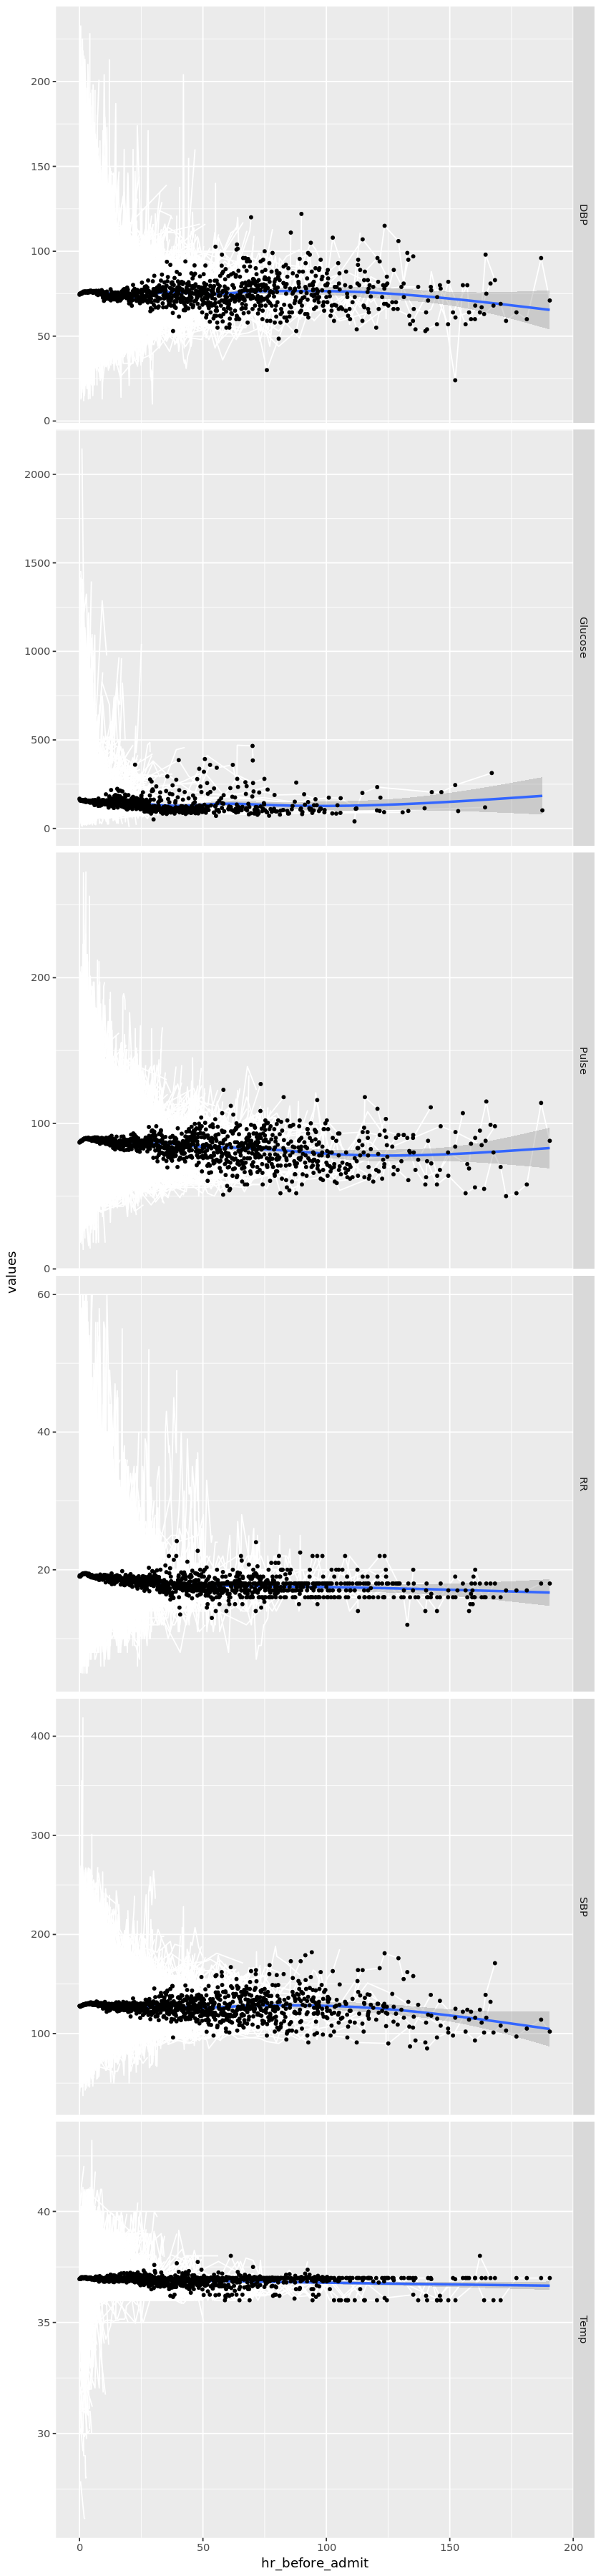

In [50]:
# this one takes a long time and the trends are all mostly flat
# although we see more fluctiation near admit_time
options(repr.plot.width=7, repr.plot.height=30)

coh_vsglu12 <- coh_vsglu %>% filter(hr_before_admit <= 200)
p <- ggplot(data = coh_vsglu12, aes(x = hr_before_admit, y = values, group = pat_enc_csn_id_coded)) + facet_grid(features ~ ., scales="free")

# use group 1 as for the whole data NOT per csn: so the smooth is not calculated separately for each csn
p + geom_line(color="white") + stat_smooth(aes(group = 1)) + stat_summary(aes(group = 1), geom = "point", size=1, fun.y = mean)